## Shapley Values
Shapley values measure the relative marginal contributions of features to a prediction.

A good primer:
https://towardsdatascience.com/the-shapley-value-for-ml-models-f1100bff78d1

Discussion of shap values for ensemble of boosted trees in Python
https://github.com/shap/shap/issues/112

In [1]:
# Necessary packages
import sklearn 
import shap
import xgboost

In [2]:
# Housing price dataset
X, y = shap.datasets.california(n_points=1000)
X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

[17:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


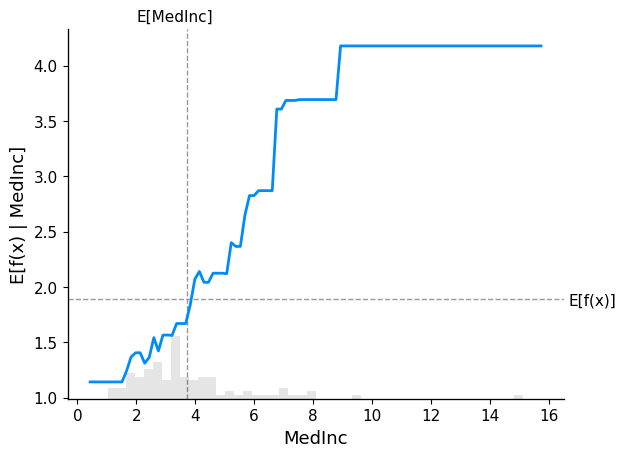

In [3]:
# train XGBoost model
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# Generate SHAP values
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

In [ ]:
# Partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_xgb.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False
)

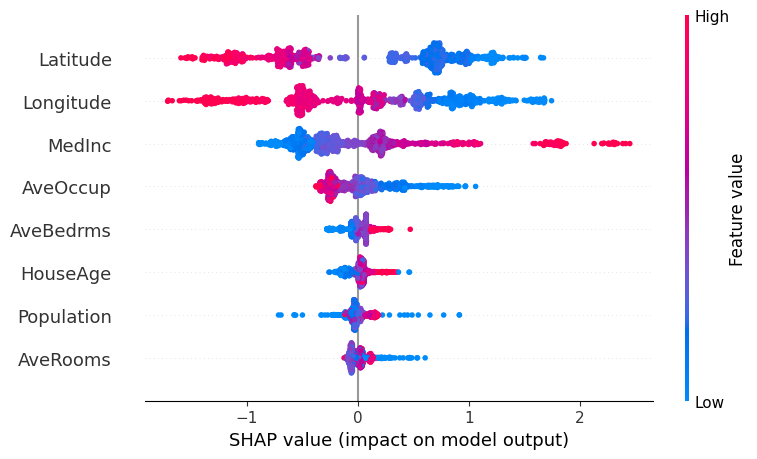

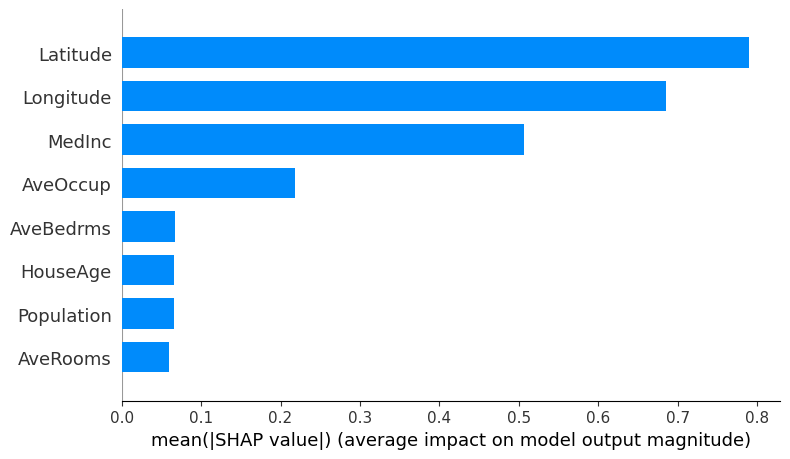

In [5]:
# Output Shapley values
shap.summary_plot(shap_values_xgb)
shap.summary_plot(shap_values_xgb, plot_type="bar")